In [28]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import Loss
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd

In [29]:
tfd = tfp.distributions
# run_opts = tf.compat.v1.RunOptions(report_tensor_allocations_upon_oom = True)
tf.random.set_seed(42)

In [30]:
class Encoder(Model):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        initializer = tf.keras.initializers.GlorotNormal(seed=42)
        self.dense1 = Dense(500, activation='relu', kernel_initializer=initializer)
        self.dense2 = Dense(500, activation='relu', kernel_initializer=initializer)
        self.dense3 = Dense(128, activation='relu', kernel_initializer=initializer)
        self.dense4 = Dense(latent_dim, activation='softplus', kernel_initializer=initializer)

    def sample(self, alpha_hat, alpha, beta):
        shape = (alpha_hat.get_shape().as_list()[-2],alpha_hat.get_shape().as_list()[-1])
        u = tf.random.uniform(shape=shape, minval=0, maxval=1)
        v = tf.math.multiply(u,alpha)
        v = tf.math.multiply(v, tf.math.exp(tf.math.lgamma(alpha)))
        v = tf.math.pow(v, tf.math.divide(1.0,alpha))
        v = tf.math.divide(v,beta)
        z = tf.math.divide(v,tf.math.reduce_sum(v)) #sum to one
        #z ,_= tf.linalg.normalize(v)

        return z, v

    def call(self, inputs):
        x = inputs[0]
        alpha = inputs[1]
        beta = inputs[2]
        #x = tf.reshape(x, (-1,28*28))
        alpha_hat = self.dense1(x)
        alpha_hat = self.dense2(alpha_hat)
        #alpha_hat = self.dense3(alpha_hat)
        alpha_hat = self.dense4(alpha_hat)
        z, v = self.sample(alpha_hat, alpha, beta)
        return z, alpha_hat, v

In [31]:
class Decoder(Model):
    def __init__(self, original_shape):
        super(Decoder, self).__init__()
        initializer = tf.keras.initializers.GlorotNormal(seed=42)
        self.dense1 = Dense(500, activation='relu',kernel_initializer=initializer)
        self.dense2 = Dense(256, activation='relu',kernel_initializer=initializer)
        self.dense3 = Dense(512, activation='relu',kernel_initializer=initializer)
        self.dense4 = Dense(original_shape, activation='sigmoid',kernel_initializer=initializer)

    def call(self, x):
        x_hat = self.dense1(x)
        #x_hat = self.dense2(x_hat)
        #x_hat = self.dense3(x_hat)
        x_hat = self.dense4(x_hat)
        #x_hat = tf.reshape(x_hat,[-1,28,28])
        return x_hat

In [32]:
class DirVAE(Model):
    def __init__(self, latent_dim, original_dim):
        super(DirVAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(original_dim)

    def compile(self, optimizer, loss):
        super().compile(optimizer)
        self.loss = loss

    def call(self, inputs):
        z, alpha_hat, v = self.encoder(inputs)
        x_hat = self.decoder(z)
        return x_hat, z, alpha_hat, v

In [33]:
@tf.function
def ELBO(log_likelihood_loss, y_pred, y_true, alpha, alpha_hat):
    ll_loss = log_likelihood_loss(y_true, y_pred)

    kld_loss = tf.math.subtract(tf.math.lgamma(alpha), tf.math.lgamma(alpha_hat))
    kld_loss = tf.math.add(kld_loss, tf.math.multiply(tf.math.subtract(alpha_hat, alpha),tf.math.digamma(alpha_hat)))
    kld_loss = tf.reduce_sum(kld_loss)

    return (tf.math.add(ll_loss, tf.math.maximum(0.0,kld_loss))), ll_loss, kld_loss

In [34]:
@tf.function
def update_alpha_mme(z, samples=1, epsilon=1e-13):
    
    epsilon = tf.convert_to_tensor(epsilon)
    dirichlet = tfd.Dirichlet(z)
    p_set = dirichlet.sample([samples])
    _, N, K = p_set.shape
    p_set = tf.reshape(p_set, (100,50,))

    mu1_tilde = tf.math.reduce_mean(p_set, axis=0)
    mu2_tilde = tf.math.reduce_mean(tf.math.pow(p_set,2), axis=0)

    S = tf.math.reduce_mean(tf.math.divide((tf.math.subtract(mu1_tilde, mu2_tilde)), (tf.math.subtract(mu2_tilde, tf.math.pow(mu1_tilde,2))) + epsilon), axis=0)

    alpha = tf.math.multiply(tf.math.divide(S,N), tf.math.reduce_sum(p_set, axis=0)) + epsilon

    return alpha

In [35]:
def ClipIfNotNone(grad):
            if grad is None:
                return grad
            return tf.clip_by_value(grad, -1000, 1000)

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
___________________________
_____EPOCH_0________
___________________________
Training loss at step 0: 682.2173
LL loss at step 0: 69.3147
kld loss at step 0: 612.9026

Training loss at step 250: 29.1626
LL loss at step 250: 26.6285
kld loss at step 250: 2.5341

Training loss at step 500: 25.9050
LL loss at step 500: 24.9261
kld loss at step 500: 0.9789

AVERAGE VALIDATION LOSS: 27.602295

RECONSTRUCTED


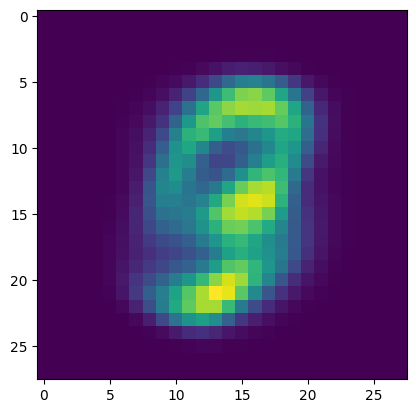


ORIGINAL


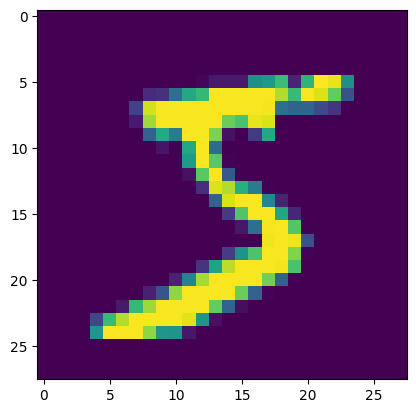

___________________________
_____EPOCH_1________
___________________________
Training loss at step 0: 26.9271
LL loss at step 0: 25.8011
kld loss at step 0: 1.1260

Training loss at step 250: 26.5095
LL loss at step 250: 25.7964
kld loss at step 250: 0.7131

Training loss at step 500: 26.4463
LL loss at step 500: 26.0240
kld loss at step 500: 0.4223

AVERAGE VALIDATION LOSS: 26.84977

___________________________
_____EPOCH_2________
___________________________
Training loss at step 0: 26.0556
LL loss at step 0: 25.6266
kld loss at step 0: 0.4289

Training loss at step 250: 26.2579
LL loss at step 250: 25.9379
kld loss at step 250: 0.3200

Training loss at step 500: 26.1486
LL loss at step 500: 25.8650
kld loss at step 500: 0.2835

AVERAGE VALIDATION LOSS: 26.565998

___________________________
_____EPOCH_3________
___________________________
Training loss at step 0: 25.7798
LL loss at step 0: 25.6264
kld loss at step 0: 0.1534

Training loss at step 250: 25.0248
LL loss at step 250: 24

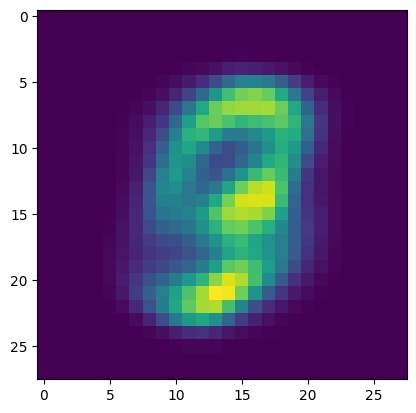


ORIGINAL


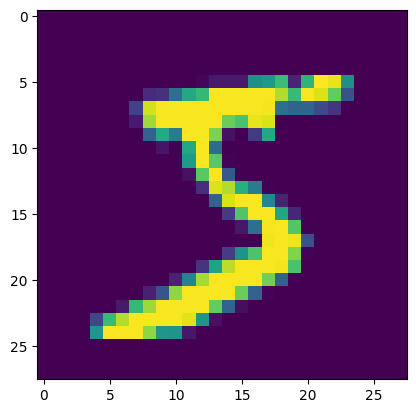

___________________________
_____EPOCH_11________
___________________________
Training loss at step 0: 26.4497
LL loss at step 0: 26.4478
kld loss at step 0: 0.0020

Training loss at step 250: 26.2883
LL loss at step 250: 26.2857
kld loss at step 250: 0.0026

Training loss at step 500: 26.1299
LL loss at step 500: 26.1272
kld loss at step 500: 0.0027

AVERAGE VALIDATION LOSS: 26.321812

___________________________
_____EPOCH_12________
___________________________
Training loss at step 0: 25.9157
LL loss at step 0: 25.9137
kld loss at step 0: 0.0021

Training loss at step 250: 25.8814
LL loss at step 250: 25.8797
kld loss at step 250: 0.0017

Training loss at step 500: 25.8993
LL loss at step 500: 25.8976
kld loss at step 500: 0.0018

AVERAGE VALIDATION LOSS: 26.322931

___________________________
_____EPOCH_13________
___________________________
Training loss at step 0: 26.6296
LL loss at step 0: 26.6279
kld loss at step 0: 0.0017

Training loss at step 250: 26.5133
LL loss at step 250

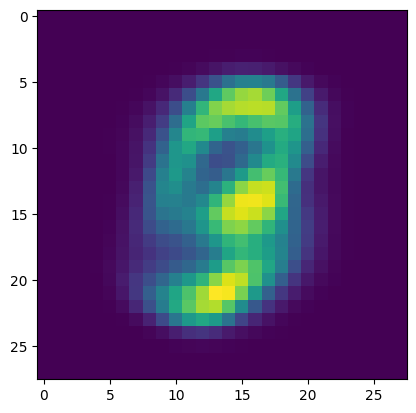


ORIGINAL


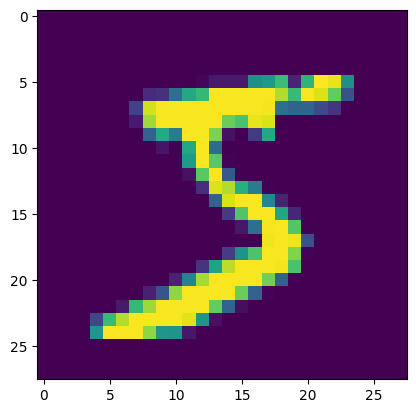

___________________________
_____EPOCH_21________
___________________________
Training loss at step 0: 1793.0139
LL loss at step 0: 25.3372
kld loss at step 0: 1767.6768

Training loss at step 250: 27.3774
LL loss at step 250: 26.1283
kld loss at step 250: 1.2490

Training loss at step 500: 27.3734
LL loss at step 500: 25.8657
kld loss at step 500: 1.5077

AVERAGE VALIDATION LOSS: 27.09198

___________________________
_____EPOCH_22________
___________________________
Training loss at step 0: 28.2380
LL loss at step 0: 27.1783
kld loss at step 0: 1.0597

Training loss at step 250: 25.8724
LL loss at step 250: 25.4766
kld loss at step 250: 0.3958

Training loss at step 500: 26.3850
LL loss at step 500: 26.0211
kld loss at step 500: 0.3639

AVERAGE VALIDATION LOSS: 26.729073

___________________________
_____EPOCH_23________
___________________________
Training loss at step 0: 25.9964
LL loss at step 0: 25.6565
kld loss at step 0: 0.3399

Training loss at step 250: 26.3982
LL loss at step

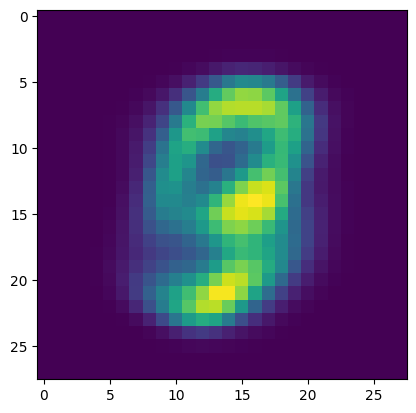


ORIGINAL


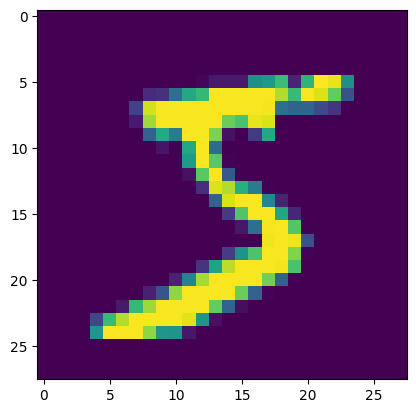

___________________________
_____EPOCH_31________
___________________________
Training loss at step 0: 25.5072
LL loss at step 0: 25.4585
kld loss at step 0: 0.0486

Training loss at step 250: 27.1778
LL loss at step 250: 27.0815
kld loss at step 250: 0.0963

Training loss at step 500: 26.8829
LL loss at step 500: 26.8113
kld loss at step 500: 0.0716

AVERAGE VALIDATION LOSS: 26.368433

___________________________
_____EPOCH_32________
___________________________
Training loss at step 0: 25.7904
LL loss at step 0: 25.7503
kld loss at step 0: 0.0401

Training loss at step 250: 26.3285
LL loss at step 250: 26.2792
kld loss at step 250: 0.0492

Training loss at step 500: 25.9768
LL loss at step 500: 25.8635
kld loss at step 500: 0.1133

AVERAGE VALIDATION LOSS: 26.35407

___________________________
_____EPOCH_33________
___________________________
Training loss at step 0: 25.2791
LL loss at step 0: 25.2477
kld loss at step 0: 0.0314

Training loss at step 250: 26.1651
LL loss at step 250:

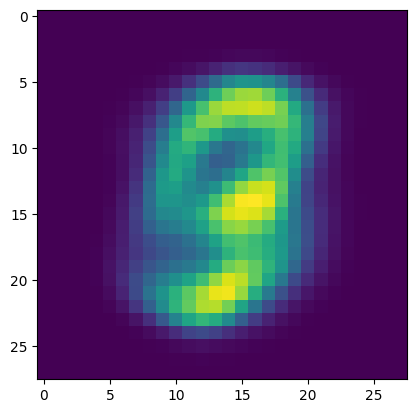


ORIGINAL


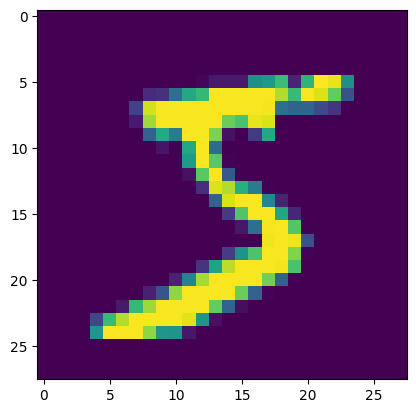

___________________________
_____EPOCH_41________
___________________________
Training loss at step 0: 1284.3448
LL loss at step 0: 26.7107
kld loss at step 0: 1257.6342

Training loss at step 250: 26.2693
LL loss at step 250: 25.3594
kld loss at step 250: 0.9100

Training loss at step 500: 27.7585
LL loss at step 500: 27.1899
kld loss at step 500: 0.5686

AVERAGE VALIDATION LOSS: 26.842093

___________________________
_____EPOCH_42________
___________________________
Training loss at step 0: 26.4406
LL loss at step 0: 26.0240
kld loss at step 0: 0.4166

Training loss at step 250: 26.1912
LL loss at step 250: 25.8253
kld loss at step 250: 0.3659

Training loss at step 500: 26.8875
LL loss at step 500: 26.5692
kld loss at step 500: 0.3183

AVERAGE VALIDATION LOSS: 26.61384

___________________________
_____EPOCH_43________
___________________________
Training loss at step 0: 25.6354
LL loss at step 0: 25.3820
kld loss at step 0: 0.2534

Training loss at step 250: 25.6579
LL loss at step

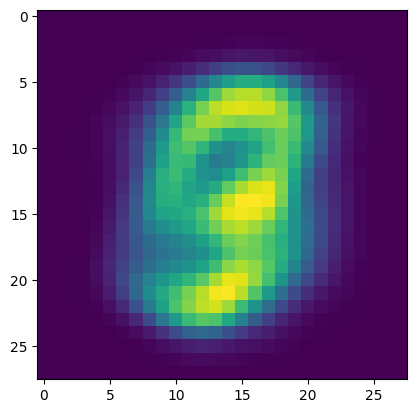


ORIGINAL


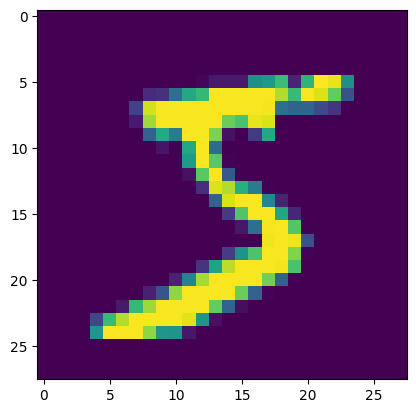

___________________________
_____EPOCH_51________
___________________________
Training loss at step 0: 25.8759
LL loss at step 0: 25.8446
kld loss at step 0: 0.0313

Training loss at step 250: 26.0393
LL loss at step 250: 25.9794
kld loss at step 250: 0.0599

Training loss at step 500: 26.6579
LL loss at step 500: 26.5899
kld loss at step 500: 0.0681

AVERAGE VALIDATION LOSS: 26.440805

___________________________
_____EPOCH_52________
___________________________
Training loss at step 0: 25.7307
LL loss at step 0: 25.5851
kld loss at step 0: 0.1456

Training loss at step 250: 26.6614
LL loss at step 250: 26.6040
kld loss at step 250: 0.0574

Training loss at step 500: 25.1683
LL loss at step 500: 25.1078
kld loss at step 500: 0.0605

AVERAGE VALIDATION LOSS: 26.380493

___________________________
_____EPOCH_53________
___________________________
Training loss at step 0: 26.6600
LL loss at step 0: 26.5587
kld loss at step 0: 0.1013

Training loss at step 250: 26.6095
LL loss at step 250

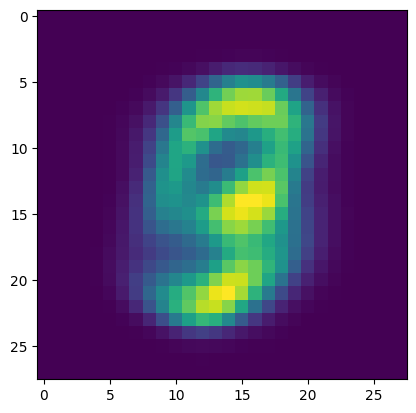


ORIGINAL


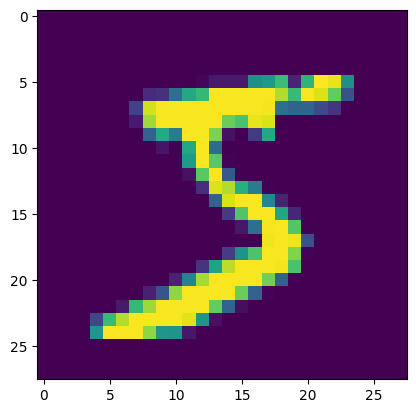

___________________________
_____EPOCH_61________
___________________________
Training loss at step 0: 1248.3439
LL loss at step 0: 25.7961
kld loss at step 0: 1222.5477

Training loss at step 250: 26.0523
LL loss at step 250: 25.7621
kld loss at step 250: 0.2903

Training loss at step 500: 26.2047
LL loss at step 500: 26.1016
kld loss at step 500: 0.1031

AVERAGE VALIDATION LOSS: 26.356268

___________________________
_____EPOCH_62________
___________________________
Training loss at step 0: 26.0365
LL loss at step 0: 25.9784
kld loss at step 0: 0.0582

Training loss at step 250: 26.1674
LL loss at step 250: 26.1304
kld loss at step 250: 0.0370

Training loss at step 500: 25.4934
LL loss at step 500: 25.4602
kld loss at step 500: 0.0332

AVERAGE VALIDATION LOSS: 26.309753

___________________________
_____EPOCH_63________
___________________________
Training loss at step 0: 26.0535
LL loss at step 0: 26.0319
kld loss at step 0: 0.0216

Training loss at step 250: 24.4994
LL loss at ste

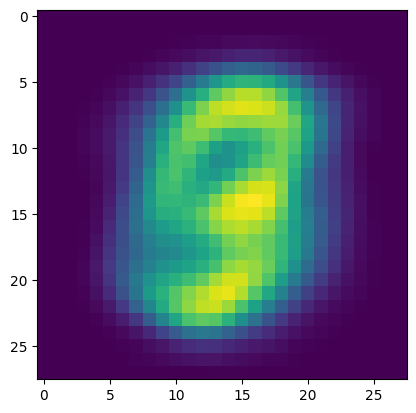


ORIGINAL


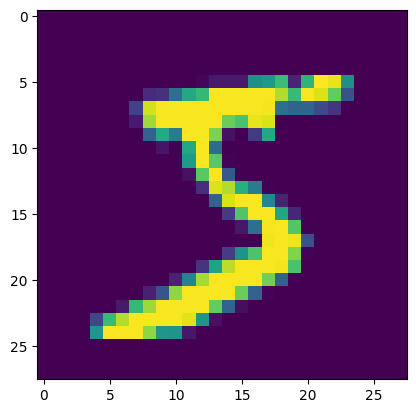

___________________________
_____EPOCH_71________
___________________________
Training loss at step 0: 25.6513
LL loss at step 0: 25.6168
kld loss at step 0: 0.0345

Training loss at step 250: 25.3624
LL loss at step 250: 25.3419
kld loss at step 250: 0.0205

Training loss at step 500: 26.3114
LL loss at step 500: 25.7159
kld loss at step 500: 0.5955

AVERAGE VALIDATION LOSS: 26.313604

___________________________
_____EPOCH_72________
___________________________
Training loss at step 0: 25.7896
LL loss at step 0: 25.7599
kld loss at step 0: 0.0297

Training loss at step 250: 25.2557
LL loss at step 250: 25.1472
kld loss at step 250: 0.1085

Training loss at step 500: 25.2424
LL loss at step 500: 25.2215
kld loss at step 500: 0.0209

AVERAGE VALIDATION LOSS: 26.319555

___________________________
_____EPOCH_73________
___________________________
Training loss at step 0: 26.6170
LL loss at step 0: 26.5792
kld loss at step 0: 0.0378

Training loss at step 250: 26.4130
LL loss at step 250

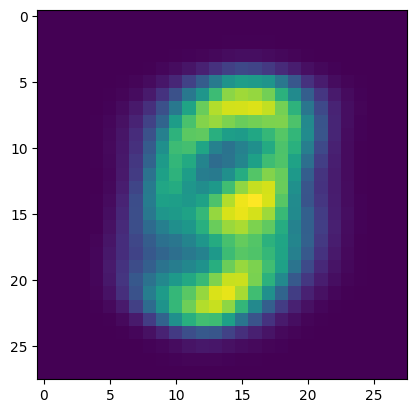


ORIGINAL


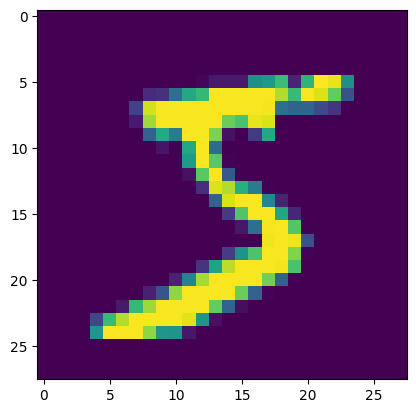

___________________________
_____EPOCH_81________
___________________________
Training loss at step 0: 1328.5598
LL loss at step 0: 25.2185
kld loss at step 0: 1303.3413

Training loss at step 250: 25.6724
LL loss at step 250: 25.3834
kld loss at step 250: 0.2890

Training loss at step 500: 26.0843
LL loss at step 500: 25.9876
kld loss at step 500: 0.0967

AVERAGE VALIDATION LOSS: 26.364845

___________________________
_____EPOCH_82________
___________________________
Training loss at step 0: 26.9113
LL loss at step 0: 26.8245
kld loss at step 0: 0.0868

Training loss at step 250: 25.7422
LL loss at step 250: 25.7086
kld loss at step 250: 0.0336

Training loss at step 500: 25.5313
LL loss at step 500: 25.5149
kld loss at step 500: 0.0164

AVERAGE VALIDATION LOSS: 26.314032

___________________________
_____EPOCH_83________
___________________________
Training loss at step 0: 26.7199
LL loss at step 0: 26.6965
kld loss at step 0: 0.0234

Training loss at step 250: 25.9513
LL loss at ste

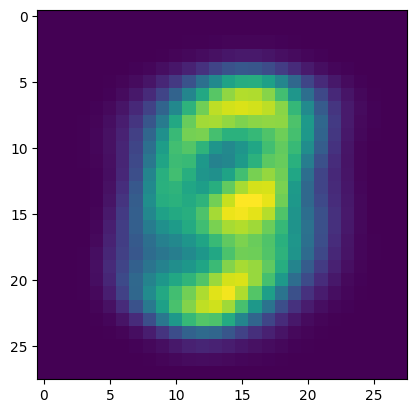


ORIGINAL


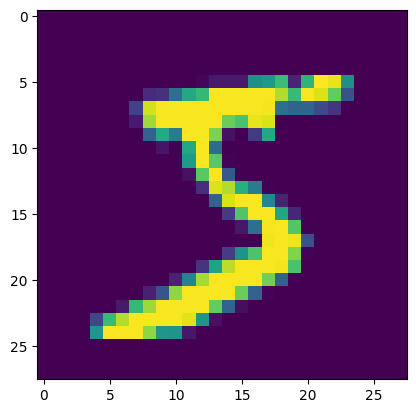

___________________________
_____EPOCH_91________
___________________________
Training loss at step 0: 26.2372
LL loss at step 0: 26.1973
kld loss at step 0: 0.0400

Training loss at step 250: 25.9470
LL loss at step 250: 25.6553
kld loss at step 250: 0.2918

Training loss at step 500: 27.0778
LL loss at step 500: 26.4782
kld loss at step 500: 0.5997

AVERAGE VALIDATION LOSS: 26.524395

___________________________
_____EPOCH_92________
___________________________
Training loss at step 0: 26.5574
LL loss at step 0: 26.3640
kld loss at step 0: 0.1934

Training loss at step 250: 24.5941
LL loss at step 250: 24.5550
kld loss at step 250: 0.0392

Training loss at step 500: 26.0687
LL loss at step 500: 26.0613
kld loss at step 500: 0.0074

AVERAGE VALIDATION LOSS: 26.307823

___________________________
_____EPOCH_93________
___________________________
Training loss at step 0: 26.2327
LL loss at step 0: 26.1968
kld loss at step 0: 0.0360

Training loss at step 250: 26.8282
LL loss at step 250

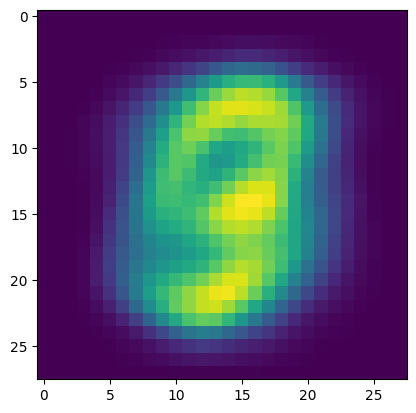


ORIGINAL


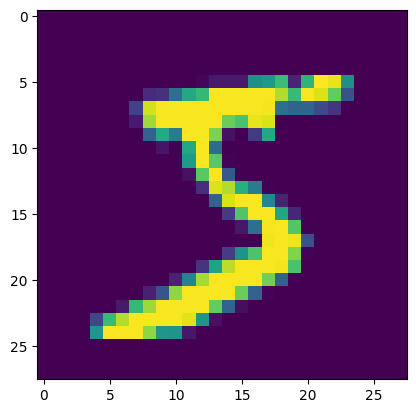

___________________________
_____EPOCH_101________
___________________________
Training loss at step 0: 13425.9492
LL loss at step 0: 26.1194
kld loss at step 0: 13399.8301

Training loss at step 250: 27.4275
LL loss at step 250: 25.9548
kld loss at step 250: 1.4727

Training loss at step 500: 25.1207
LL loss at step 500: 24.6387
kld loss at step 500: 0.4820

AVERAGE VALIDATION LOSS: 26.576994

___________________________
_____EPOCH_102________
___________________________
Training loss at step 0: 25.7571
LL loss at step 0: 25.4600
kld loss at step 0: 0.2971

Training loss at step 250: 25.9205
LL loss at step 250: 25.8326
kld loss at step 250: 0.0879

Training loss at step 500: 26.0586
LL loss at step 500: 25.9860
kld loss at step 500: 0.0726

AVERAGE VALIDATION LOSS: 26.335499

___________________________
_____EPOCH_103________
___________________________
Training loss at step 0: 26.4942
LL loss at step 0: 26.4514
kld loss at step 0: 0.0428

Training loss at step 250: 25.9164
LL loss a

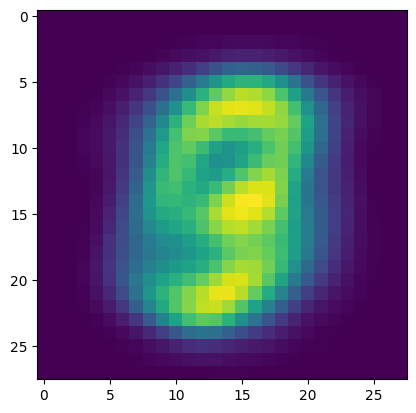


ORIGINAL


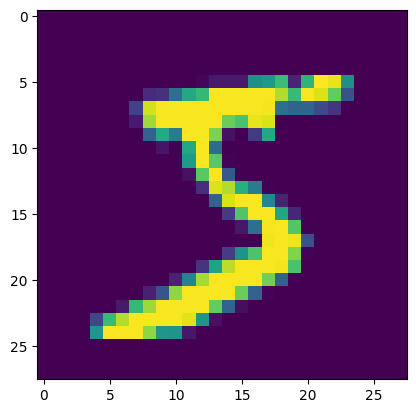

___________________________
_____EPOCH_111________
___________________________
Training loss at step 0: 25.8032
LL loss at step 0: 25.7968
kld loss at step 0: 0.0064

Training loss at step 250: 25.4085
LL loss at step 250: 25.4047
kld loss at step 250: 0.0038

Training loss at step 500: 26.2705
LL loss at step 500: 26.2683
kld loss at step 500: 0.0022

AVERAGE VALIDATION LOSS: 26.281488

___________________________
_____EPOCH_112________
___________________________
Training loss at step 0: 25.9606
LL loss at step 0: 25.9573
kld loss at step 0: 0.0033

Training loss at step 250: 25.3852
LL loss at step 250: 25.3842
kld loss at step 250: 0.0011

Training loss at step 500: 25.6594
LL loss at step 500: 25.6587
kld loss at step 500: 0.0007

AVERAGE VALIDATION LOSS: 26.280777

___________________________
_____EPOCH_113________
___________________________
Training loss at step 0: 26.5728
LL loss at step 0: 26.5713
kld loss at step 0: 0.0016

Training loss at step 250: 26.1182
LL loss at step 

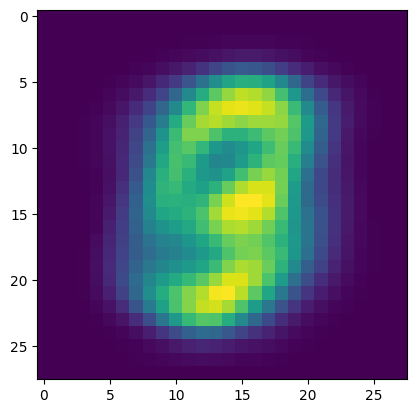


ORIGINAL


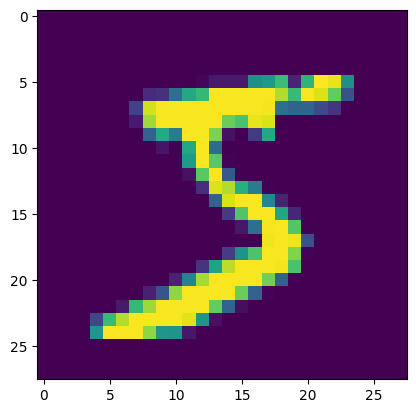

___________________________
_____EPOCH_121________
___________________________
Training loss at step 0: 2793.4758
LL loss at step 0: 25.6503
kld loss at step 0: 2767.8254

Training loss at step 250: 303.0574
LL loss at step 250: 25.4339
kld loss at step 250: 277.6235

Training loss at step 500: 65.0426
LL loss at step 500: 25.4637
kld loss at step 500: 39.5789

AVERAGE VALIDATION LOSS: 45.626694

___________________________
_____EPOCH_122________
___________________________
Training loss at step 0: 40.3223
LL loss at step 0: 26.5592
kld loss at step 0: 13.7631

Training loss at step 250: 31.1246
LL loss at step 250: 25.2533
kld loss at step 250: 5.8713

Training loss at step 500: 30.3749
LL loss at step 500: 26.2964
kld loss at step 500: 4.0785

AVERAGE VALIDATION LOSS: 29.68503

___________________________
_____EPOCH_123________
___________________________
Training loss at step 0: 28.9590
LL loss at step 0: 25.5057
kld loss at step 0: 3.4533

Training loss at step 250: 27.7146
LL loss

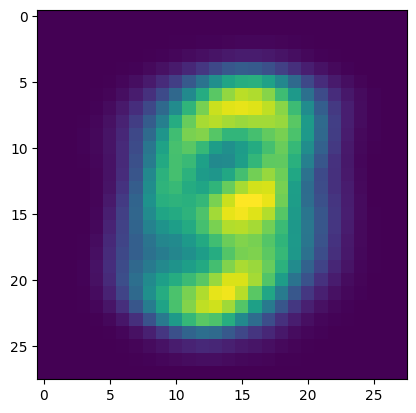


ORIGINAL


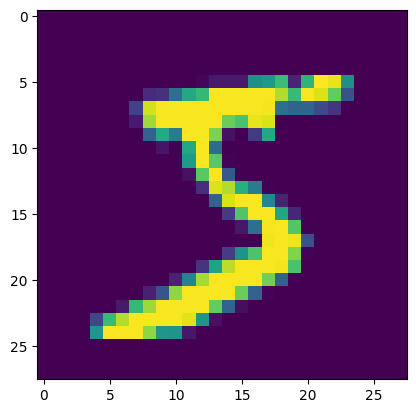

___________________________
_____EPOCH_131________
___________________________
Training loss at step 0: 26.4463
LL loss at step 0: 26.4370
kld loss at step 0: 0.0092

Training loss at step 250: 25.4927
LL loss at step 250: 25.3860
kld loss at step 250: 0.1068

Training loss at step 500: 26.3152
LL loss at step 500: 26.2993
kld loss at step 500: 0.0158

AVERAGE VALIDATION LOSS: 26.308672

___________________________
_____EPOCH_132________
___________________________
Training loss at step 0: 25.9364
LL loss at step 0: 25.9284
kld loss at step 0: 0.0080

Training loss at step 250: 25.4904
LL loss at step 250: 25.4637
kld loss at step 250: 0.0267

Training loss at step 500: 25.5950
LL loss at step 500: 25.5575
kld loss at step 500: 0.0374

AVERAGE VALIDATION LOSS: 26.443933

___________________________
_____EPOCH_133________
___________________________
Training loss at step 0: 26.9079
LL loss at step 0: 26.7926
kld loss at step 0: 0.1153

Training loss at step 250: 25.6104
LL loss at step 

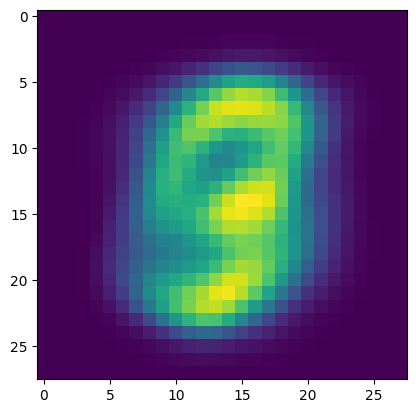


ORIGINAL


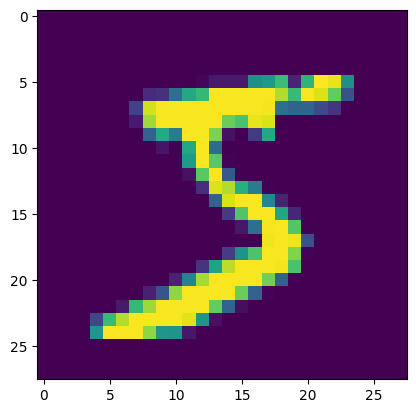

___________________________
_____EPOCH_141________
___________________________
Training loss at step 0: 12783.9229
LL loss at step 0: 25.9670
kld loss at step 0: 12757.9561

Training loss at step 250: 28.5969
LL loss at step 250: 25.7603
kld loss at step 250: 2.8366

Training loss at step 500: 27.0632
LL loss at step 500: 26.2259
kld loss at step 500: 0.8374

AVERAGE VALIDATION LOSS: 26.937107

___________________________
_____EPOCH_142________
___________________________
Training loss at step 0: 27.5346
LL loss at step 0: 26.6139
kld loss at step 0: 0.9207

Training loss at step 250: 26.6640
LL loss at step 250: 26.3077
kld loss at step 250: 0.3563

Training loss at step 500: 24.8279
LL loss at step 500: 24.6886
kld loss at step 500: 0.1392

AVERAGE VALIDATION LOSS: 26.425318

___________________________
_____EPOCH_143________
___________________________
Training loss at step 0: 26.5727
LL loss at step 0: 26.4647
kld loss at step 0: 0.1080

Training loss at step 250: 25.9886
LL loss a

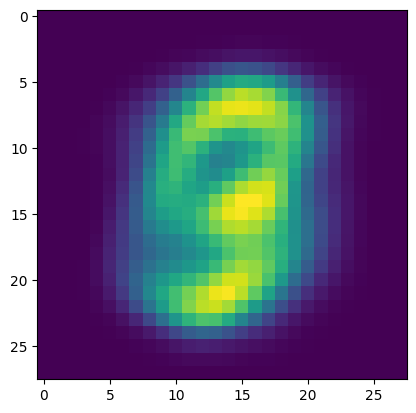


ORIGINAL


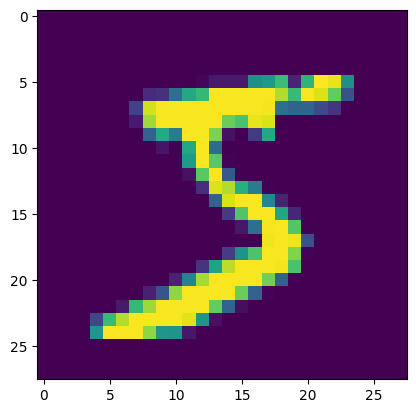

___________________________
_____EPOCH_151________
___________________________
Training loss at step 0: 26.6054
LL loss at step 0: 26.5834
kld loss at step 0: 0.0219

Training loss at step 250: 25.1855
LL loss at step 250: 25.1788
kld loss at step 250: 0.0067

Training loss at step 500: 26.1589
LL loss at step 500: 26.1545
kld loss at step 500: 0.0043

AVERAGE VALIDATION LOSS: 26.284475

___________________________
_____EPOCH_152________
___________________________
Training loss at step 0: 25.7831
LL loss at step 0: 25.7803
kld loss at step 0: 0.0028

Training loss at step 250: 27.2047
LL loss at step 250: 27.2030
kld loss at step 250: 0.0017

Training loss at step 500: 26.0649
LL loss at step 500: 26.0611
kld loss at step 500: 0.0038

AVERAGE VALIDATION LOSS: 26.282427

___________________________
_____EPOCH_153________
___________________________
Training loss at step 0: 25.9371
LL loss at step 0: 25.9349
kld loss at step 0: 0.0022

Training loss at step 250: 25.7031
LL loss at step 

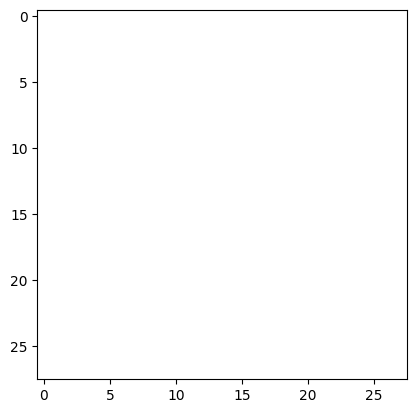


ORIGINAL


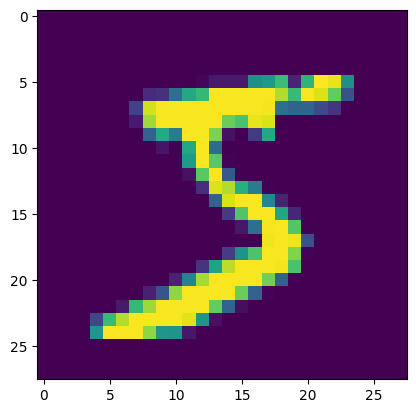

___________________________
_____EPOCH_161________
___________________________
Training loss at step 0: nan
LL loss at step 0: nan
kld loss at step 0: 110986.9219

Training loss at step 250: nan
LL loss at step 250: nan
kld loss at step 250: 17.3415

Training loss at step 500: nan
LL loss at step 500: nan
kld loss at step 500: 2.0370

AVERAGE VALIDATION LOSS: nan

___________________________
_____EPOCH_162________
___________________________
Training loss at step 0: nan
LL loss at step 0: nan
kld loss at step 0: 1.2897

Training loss at step 250: nan
LL loss at step 250: nan
kld loss at step 250: 0.4436

Training loss at step 500: nan
LL loss at step 500: nan
kld loss at step 500: 0.3148

AVERAGE VALIDATION LOSS: nan

___________________________
_____EPOCH_163________
___________________________
Training loss at step 0: nan
LL loss at step 0: nan
kld loss at step 0: 0.2568

Training loss at step 250: nan
LL loss at step 250: nan
kld loss at step 250: 0.1323

Training loss at step 500: 

KeyboardInterrupt: 

In [36]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train_reshaped = x_train.reshape((-1,28*28)).astype("float32") / 255
x_test_reshaped = x_test.reshape((-1,28*28)).astype("float32") / 255

print('GPU:', tf.config.list_physical_devices('GPU'))
tf.config.run_functions_eagerly(False)

latent_dim = 50
original_dim = 28*28

model = DirVAE(latent_dim, original_dim)

log_likelihood_loss = tf.keras.losses.BinaryCrossentropy(reduction='sum')
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

batch_size = 100
alpha = (1.0-(1.0/latent_dim)) * tf.ones((latent_dim,))
beta = 1.0 * tf.ones((latent_dim,))

train_dataset = tf.data.Dataset.from_tensor_slices((x_train_reshaped))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test_reshaped))
test_dataset = test_dataset.shuffle(buffer_size=1024).batch(batch_size)

lowest_loss = np.inf
epochs = 1000

# Training Loop with Gradient Accumulation and RAM Logging
for epoch in range(epochs):
    print('___________________________')
    print(f'_____EPOCH_{epoch}________')
    print('___________________________')
    for step, x_batch_train in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            prediction, z, alpha_hat, v = model([x_batch_train, alpha, beta], training=True)
            loss_value, ll_loss, kld_loss = ELBO(log_likelihood_loss, prediction, x_batch_train, alpha, alpha_hat)

        grads = tape.gradient(loss_value, model.trainable_weights)
        grads = [ClipIfNotNone(grad) for grad in grads]
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        if step % 250 == 0:
            print(f"Training loss at step {step}: {float(loss_value):.4f}")
            print(f"LL loss at step {step}: {float(ll_loss):.4f}")
            print(f"kld loss at step {step}: {float(kld_loss):.4f}\n")


    val_loss = []
    for step, (x_batch_test) in enumerate(test_dataset):
        val_prediction, val_z, val_alpha_hat, val_v = model([x_batch_test, alpha, beta], training=False)
        val_loss_value, val_ll_loss, val_kld_loss = ELBO(log_likelihood_loss, val_prediction, x_batch_test, alpha, val_alpha_hat)
        val_loss.append(val_loss_value.numpy())
    val_loss = np.mean(np.array(val_loss))
    print('AVERAGE VALIDATION LOSS:', val_loss)
    print()

    ##UPDATE ALPHA
    if epoch % 20 == 0 and epoch != 0:
        alpha = update_alpha_mme(v)
        print('Alpha:', alpha.numpy())
        
    if epoch % 10 == 0:
        inputs = [
            tf.convert_to_tensor(x_train[0].reshape((1,28*28))),
            alpha,
            beta
        ]

        image, img_z, img_alpha_hat, img_v = model(inputs)
        print("RECONSTRUCTED")
        plt.imshow(image[0].numpy().reshape((28,28)))
        plt.show()
        print()
        print("ORIGINAL")
        plt.imshow(x_train[0])
        plt.show()

    if val_loss_value.numpy() < lowest_loss:
        model.save_weights('my_model', overwrite=True, save_format='tf', options=None)
        lowest_loss = val_loss_value.numpy()

print('FINAL ALPHA:', alpha.numpy())
FINAL_ALPHA = alpha

In [ ]:
# z = tf.random.uniform(shape=(100,50), minval=1, maxval=10)
# #z = tf.math.divide(z, tf.math.reduce_sum(z))
# samples=1
# dirichlet = tfd.Dirichlet(z)
# p_set = dirichlet.sample([samples])
# print('p_set', p_set)
# _, N, K = p_set.shape

# p_set = tf.reshape(p_set, (100,50,))
# print('p_set shape', p_set.shape)

# mu1_tilde = tf.math.reduce_mean(p_set, axis=0)
# mu2_tilde = tf.math.reduce_mean(tf.math.pow(p_set,2), axis=0)

# print('mu1tilde shape', mu1_tilde.shape)
# print('mu2tilde shape', mu2_tilde.shape)

# S = tf.math.reduce_mean(tf.math.divide((tf.math.subtract(mu1_tilde, mu2_tilde)), (tf.math.subtract(mu2_tilde, tf.math.pow(mu1_tilde,2)))), axis=0)
# print('s shape', S.shape)
# alpha = tf.math.multiply(tf.math.divide(S,N), tf.math.reduce_sum(p_set, axis=0))
# print('alpha shape', alpha.shape)

In [ ]:
alpha